## Resize

In this lesson we will show a comparison between classical resizing (rescaling) and seam carving.

In the first practical class you learned how to change the size of an image by rescaling it with `cv2.resize()` function.

This function uses interpolation methods to create new pixels and assign them a color/intensity value.

Remember that the syntax of resize function is the following:

`cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])`
where:
* *src*	[required]: source/input image
* *dsize*	[required]: desired size for the output image
* *fx*	[optional]: scale factor along the horizontal axis
* *fy*	[optional]: scale factor along the vertical axis
* *interpolation*	[optional]: flag that takes one of the following methods: 
1.   INTER_NEAREST – a nearest-neighbor interpolation INTER_LINEAR – a bilinear interpolation (used by default);
2.   INTER_AREA – resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method;
3.   INTER_CUBIC – a bicubic interpolation over 4×4 pixel neighborhood;
4.   INTER_LANCZOS4 – a Lanczos interpolation over 8×8 pixel neighborhood

This method does not adapt to the content of the image, so the content will be simply stretched to fit the new dimensions.

Let's import necessary libraries and the given image.

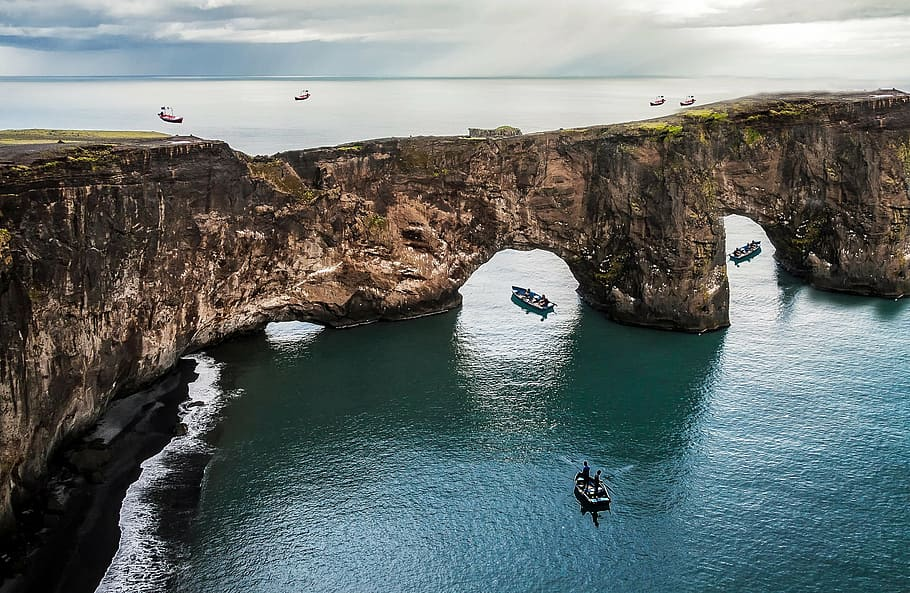

In [ ]:
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("boats.jpg")
cv2_imshow(img)

Let's show the initial dimensions of the image.

In [ ]:
print('The initial image dimensions are: ')
print(img.shape)

The initial image dimensions are: 
(593, 910, 3)


Image reseize can be performed in 2 manners:
1. We can specify the desired size of the output image directly by entering a tuple with the number of pixels in (x,y) as arguments
2. We can reduce/increase the dimensions by a specific factor


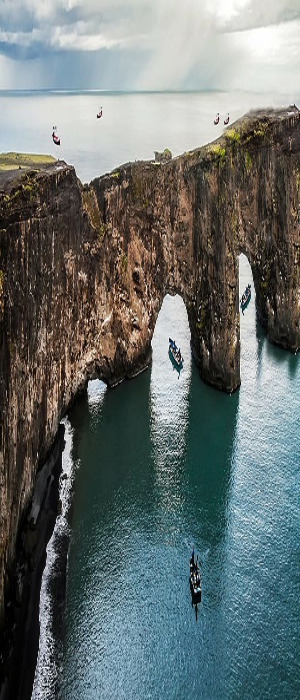

In [ ]:
#Resizing to specified dimensions (1)
resized1 = cv2.resize(img,(300,700), cv2.INTER_CUBIC)
cv2_imshow(resized1)

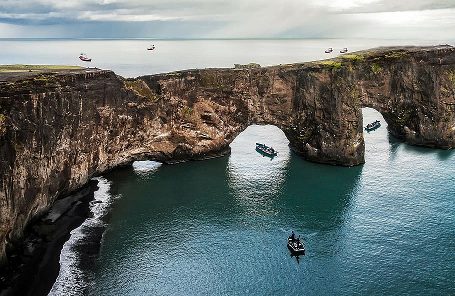

In [ ]:
#Resize with a scale factor 
resized2 = cv2.resize(src=img,dsize=None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC)
cv2_imshow(resized2)

Moreover we can also increase/decrease one dimension while keeping the other unchanged.

This can be done by simply setting one of the factors equal to the scaling value (e.g. 3 = tripled dimension) and the other equal to 1. 


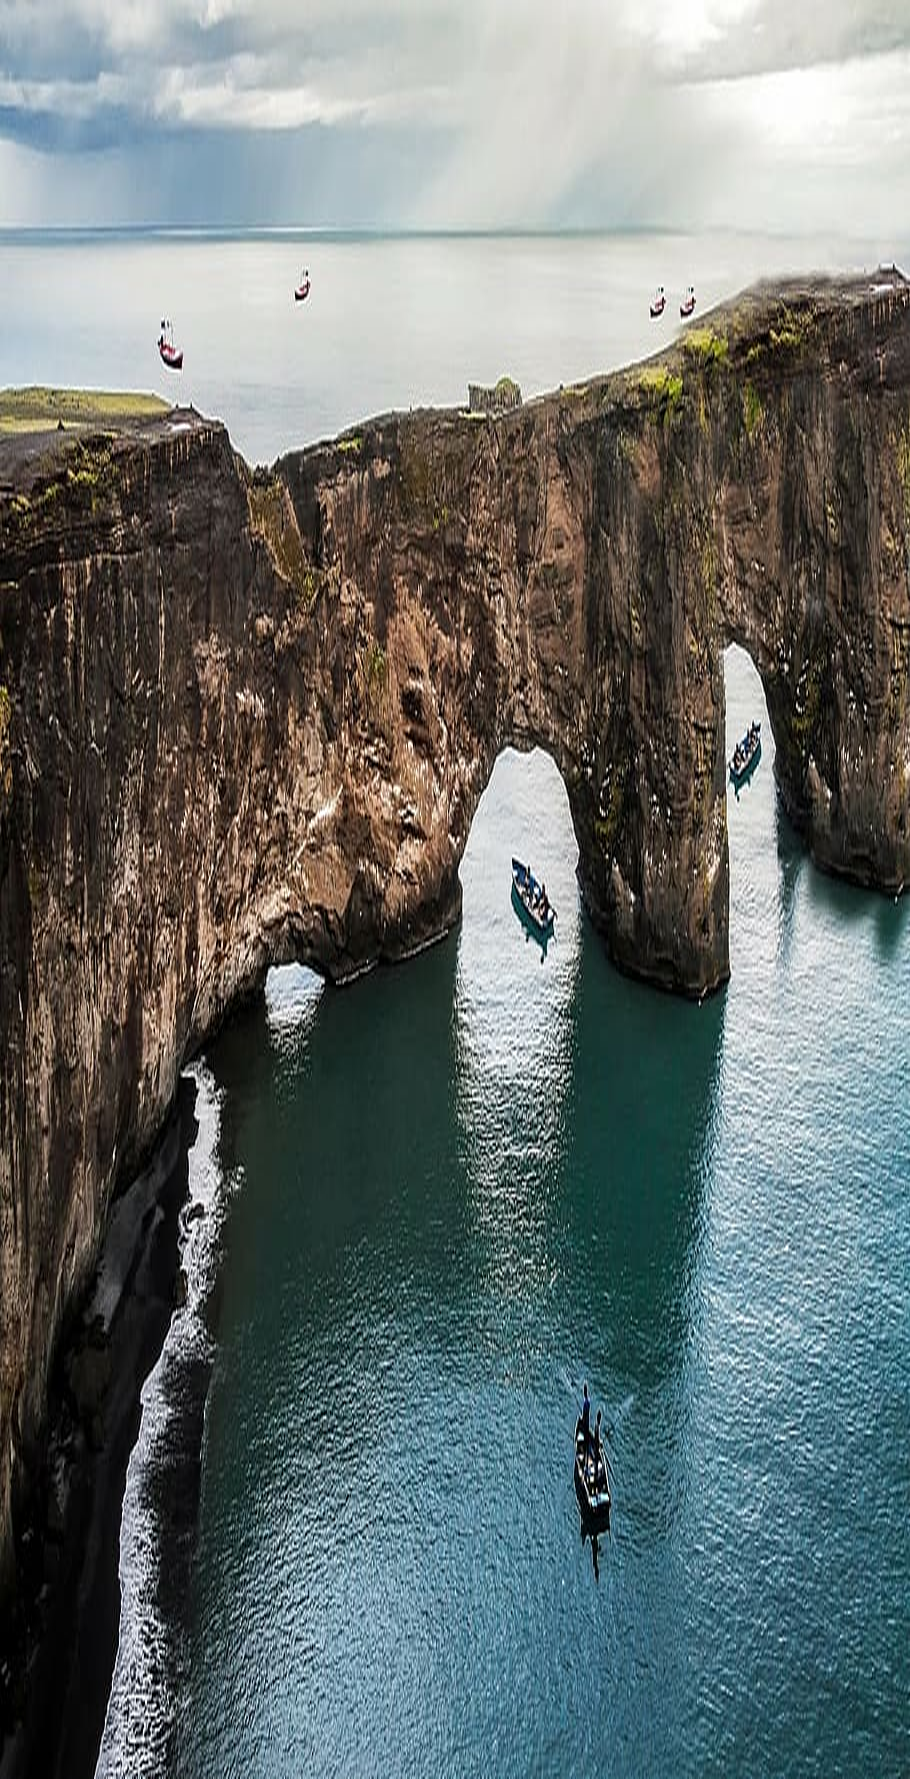

In [ ]:
resized3 = cv2.resize(src=img,dsize=None,fx=1,fy=3, interpolation = cv2.INTER_CUBIC)
cv2_imshow(resized3)

As it is possible to see this procedure isn't content-aware, meaning that the size changes doesn't take into account the relative proportions of objects contained in the image, which can undergo significant changes and loose their meaning.

## Seam Carving

Seam carving is a method that overcomes this limitation
preserving the most salient (i.e., “interesting”) regions of an image while still resizing the image itself.

It applies heuristics/path finding derived from the energy map to determine which regions of the image can be removed or duplicated to ensure:
1. All “interesting” regions of the image are preserved 
2. This is done without introducing artifacts

OpenCV does not provide a function to directly perform seam carving, hence we will use the implementation offered by https://pypi.org/project/seam-carving/.

Let's start importing the needed libraries and making a copy of the original image that we'd like to resize.

In [ ]:
pip install seam_carving

In [ ]:
import numpy as np
import seam_carving

img_copy = img.copy()

***Seam carving*** algorithm works as follows:
1. Assign an energy value to every pixel
2. Find an 8-connected path of the pixels with the least energy
3. Delete all the pixels in the path
4. Repeat 1-3 till the desired number of rows/columns are deleted

Step 1 is to compute an energy value for every pixel.

We apply a sobel filter to compute:
- the partial derivative in the x axis
- the partial derivative in the y axis
- Sum their absolute values

With openCV we already know how to perform this computation with openCV.

(-0.5, 909.5, 592.5, -0.5)

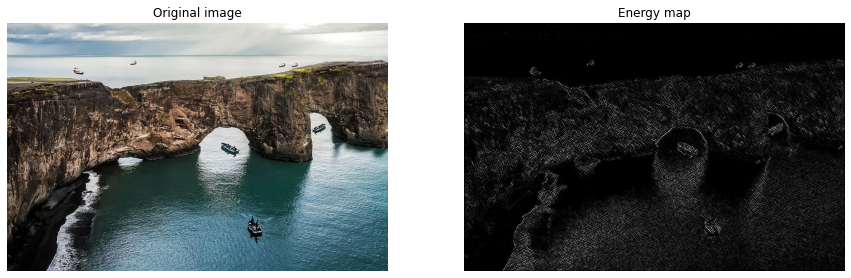

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
energy = cv2.Sobel(gray, -1, 1,1,ksize=3) # Apply Sobel Filter: first order derivative around x


fig = plt.figure(figsize=[15,15])

fig.add_subplot(1,2,1).set_title('Original image')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(1,2,2).set_title('Energy map')
plt.imshow(energy,cmap='gray')
plt.axis('off')


Clearly, the areas with minimal variation, such as the mountains, have very low energy (dark). 

When we run the seam carving algorithm, the lines removed with tend to closely associate with these parts of the image, while attempting to preserve the high energy parts(light).

Let's apply the `seam_carving.resize` function.

The syntax is `seam_carving.resize(img, (w,h), energy_mode, order, keep_mask)` and the needed inputs are:

* *img* : Input image whose seams are to be removed.
* *(w,h)* : desired final image sizes. The algorthm will automatically apply vertical, horizontal or simultaneous seam carving to achieve this dimensions.
* *energy_mode* : str {`backward’, ‘forward’}
Indicates whether we use the backward or forward method to search for tha optimal seams.
* *order* : The image width and height could be changed simultaneously. The order of vertical and horizontal seams has little to do with the final results. Currently this package only support two kinds of seams-order: width-first and height-first. In width-first mode, we remove/insert all vertical seams first, and then the horizontal ones, while height-first is the opposite.
* *keep_mask* : mask that identifies a zone that is free from seam removal and insertion.

(-0.5, 609.5, 592.5, -0.5)

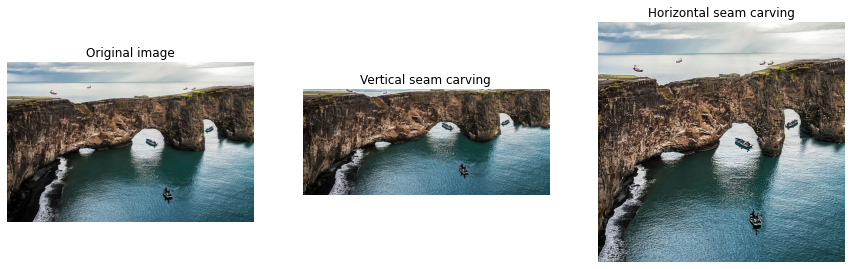

In [ ]:
src_h, src_w, _ = img.shape
vertical_seam = seam_carving.resize(img_copy, (src_w, src_h-200), energy_mode='backward', order='width-first', keep_mask=None)
horizontal_seam = seam_carving.resize(img_copy, (src_w-300, src_h), energy_mode='backward', order='width-first', keep_mask=None)

fig = plt.figure(figsize=[15,15])

fig.add_subplot(1,3,1).set_title('Original image')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(1,3,2).set_title('Vertical seam carving')
plt.imshow(cv2.cvtColor(vertical_seam,cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(1,3,3).set_title('Horizontal seam carving')
plt.imshow(cv2.cvtColor(horizontal_seam,cv2.COLOR_BGR2RGB))
plt.axis('off')

As you see in vertical seam carving the lowest energy part (the sky in the gradient map) is completely removed.

## Object removal

With this content-aware procedure we can also remove objects froma  scene.

Let's try to remove the small boat at the bottom of the image.

In order to do so we need to define a binary mask to identify the region of interest in the image.
(hint: the boat is paced at pixels [440:550,520:670])

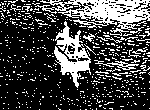

In [ ]:
#ROI extraction
M = img[440:550,520:670]

#Mask creation
M_gray = cv2.cvtColor(M, cv2.COLOR_BGR2GRAY)
ret,M_bin = cv2.threshold(M_gray,70,255,cv2.THRESH_BINARY_INV)

cv2_imshow(M_bin)

Remember that the final mask should be of the same size of the original image, so we add borders to fill the gaps (zero padding).

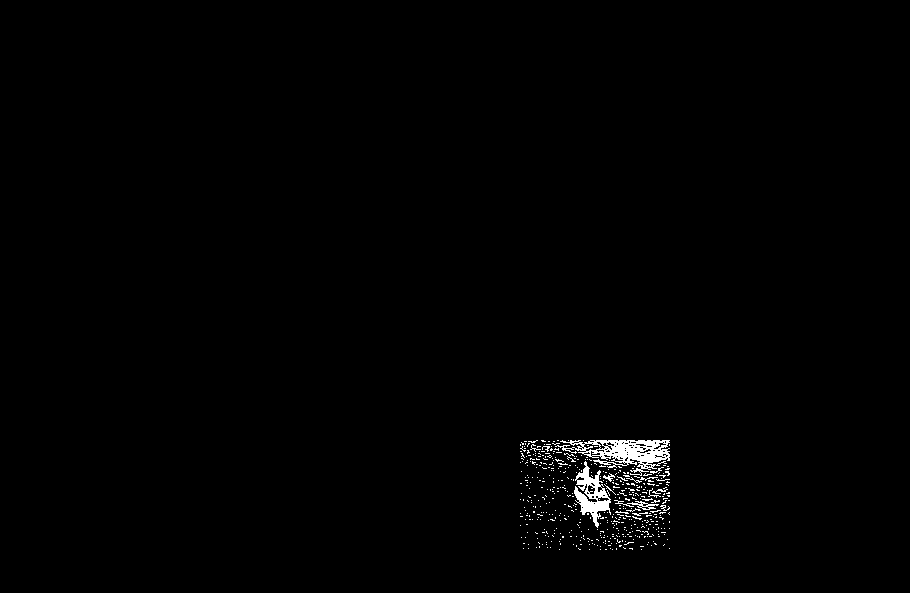

In [ ]:
color_borders = [0,0,0]
mask= cv2.copyMakeBorder(M_bin.copy(),440,593-550,520,910-670,cv2.BORDER_CONSTANT,value=color_borders)

cv2_imshow(mask)

Let's apply object removal using the function `seam_carving.remove_object(src, drop_mask=mask, keep_mask=None)`

where *drop_mask* indicates the object to be removed.

(-0.5, 780.5, 592.5, -0.5)

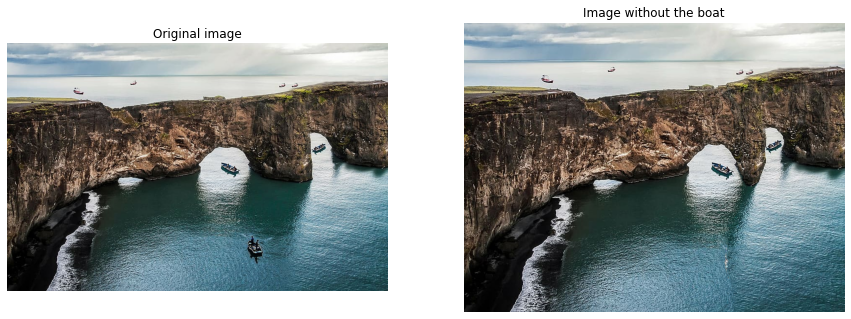

In [ ]:
noBoat_img = seam_carving.remove_object(img, drop_mask=mask, keep_mask=None)
fig = plt.figure(figsize=[15,15])

fig.add_subplot(1,2,1).set_title('Original image')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')

fig.add_subplot(1,2,2).set_title('Image without the boat')
plt.imshow(cv2.cvtColor(noBoat_img,cv2.COLOR_BGR2RGB))
plt.axis('off')

